In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import logomaker

In [2]:
def simplify_motif_name(name):
    """
    """
#     new_name = name.split('/')[0]
    new_name = name.split('(')[0]
    return new_name

def simplify_enhclst_name(name):
    """
    """
    if name.startswith('clst'):
        name = name[4:]
    new_name = name.split('_')[0]
    return new_name

def p2f(text):
    """Convert percentage to float 
    """
    return np.float(text.strip('%'))/100

# Load data 

In [3]:
MERGE_SIMILAR_MOTIFS = True 
MERGE_SIMILAR_MOTIFS_ADHOC = False 



today = datetime.date.today()
output_figures = "/cndd2/fangming/projects/scf_enhancers/results/{{}}_{}.pdf".format(today)
print(output_figures)
print(today)

/cndd2/fangming/projects/scf_enhancers/results/{}_2020-09-30.pdf
2020-09-30


In [4]:
# 418 vs 234
    
# all motif pwms
f_pattern = "/cndd2/fangming/software/homer/motifs/*.motif"
files = np.sort(glob.glob(f_pattern))

motif_pwms = {}
for file in files:
    df = pd.read_csv(file, sep='\t', skiprows=1, header=None)
    df.columns = ['A', 'C', 'G', 'T']
    
    with open(file, 'r') as fh:
        header = fh.readline()
        name = header.split('\t')[1]
        simp_name = simplify_motif_name(name) 
    
    if simp_name not in motif_pwms.keys():
        motif_pwms[simp_name] = df

all_motifs = np.sort(list(motif_pwms.keys()))

# groupby all motif clusters 
f = '/cndd2/fangming/references/homer_known_motif_clusters.pkl'
with open(f, 'rb') as fh:
    known_motif_clusters = pickle.load(fh)
    print(len(known_motif_clusters))

similar_motif_dict = {}
for motif_clst in known_motif_clusters:
    for motif in motif_clst:
        similar_motif_dict[motif] = motif_clst[0]
# similar_motif_dict = pd.Series(similar_motif_dict)

if MERGE_SIMILAR_MOTIFS:

    # use the first element in each motif cluster as the representative
    all_motifs = [clst[0] for clst in known_motif_clusters]


print(len(all_motifs))    
print(len(similar_motif_dict))
df.head() 

234
234
418


A      C      G      T
0  0.092  0.351  0.370  0.187
1  0.302  0.419  0.143  0.135
2  0.183  0.395  0.219  0.204
3  0.574  0.032  0.215  0.179
4  0.167  0.032  0.785  0.016

In [5]:
# HOMER all motif enrichment results
# cluster by conditions (all, correlated, linked)

f_pattern = '/cndd2/fangming/projects/scf_enhancers/motifs/20200907/*/knownResults.txt'
files = np.sort(glob.glob(f_pattern))

motif_res = {}
for file in files:
    clst, catg = file.split('/')[-2].split('_')[-2:]
    df = pd.read_csv(file, sep="\t")
    df['Motif Name'] = df['Motif Name'].apply(simplify_motif_name)
    df = df.groupby('Motif Name').first() # remove dup
    df = df.reindex(all_motifs)
    motif_res["{}_{}".format(clst, catg)] = df
    
    df.columns = ['consensus', 'p', 'logp', 'q', 'num_fg', 'frac_fg', 'num_bg', 'frac_bg']
    df['frac_fg'] = df['frac_fg'].apply(p2f)
    df['frac_bg'] = df['frac_bg'].apply(p2f)
    
    print(clst, catg, df.shape)

clst0 all (234, 8)
clst0 correlated (234, 8)
clst0 linked (234, 8)
clst1 all (234, 8)
clst1 correlated (234, 8)
clst1 linked (234, 8)
clst2 all (234, 8)
clst2 correlated (234, 8)
clst2 linked (234, 8)
clst3 all (234, 8)
clst3 correlated (234, 8)
clst3 linked (234, 8)
clst4 all (234, 8)
clst4 correlated (234, 8)
clst4 linked (234, 8)
clst5 all (234, 8)
clst5 correlated (234, 8)
clst5 linked (234, 8)
clst6 all (234, 8)
clst6 correlated (234, 8)
clst6 linked (234, 8)
clst7 all (234, 8)
clst7 correlated (234, 8)
clst7 linked (234, 8)
clst8 all (234, 8)
clst8 correlated (234, 8)
clst8 linked (234, 8)
clst9 all (234, 8)
clst9 correlated (234, 8)
clst9 linked (234, 8)


In [6]:
# q-value
mat_qval = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_qval[key] = val['q'] # match axis
print(mat_qval.shape)
    
# log2FC
mat_fc = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_fc[key] = np.log2(val['frac_fg']/val['frac_bg']) # match axis
print(mat_fc.shape)
 
# Counts_fg
mat_fg = pd.DataFrame(index=df.index) 
mat_nfg = pd.DataFrame(index=df.index) 
total_fg = {}
for key, val in motif_res.items():
    # match axis (df index)
    total_fg[key] = int((val['num_fg']/val['frac_fg']).median())
    mat_fg[key] = val['num_fg']
    mat_nfg[key] = total_fg[key] - val['num_fg']
    
print(mat_fg.shape)

# Counts_bg
mat_bg = pd.DataFrame(index=df.index) 
mat_nbg = pd.DataFrame(index=df.index) 
total_bg = {}
for key, val in motif_res.items():
    # match axis (df index)
    total_bg[key] = int((val['num_bg']/val['frac_bg']).median())
    mat_bg[key] = val['num_bg']
    mat_nbg[key] = total_bg[key] - val['num_fg']
    
print(mat_bg.shape)

(234, 30)
(234, 30)
(234, 30)
(234, 30)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


4.0


<ipython-input-7-731472478e7f>:2: RuntimeWarning: divide by zero encountered in log10
  _x = -np.log10(mat_qval).values


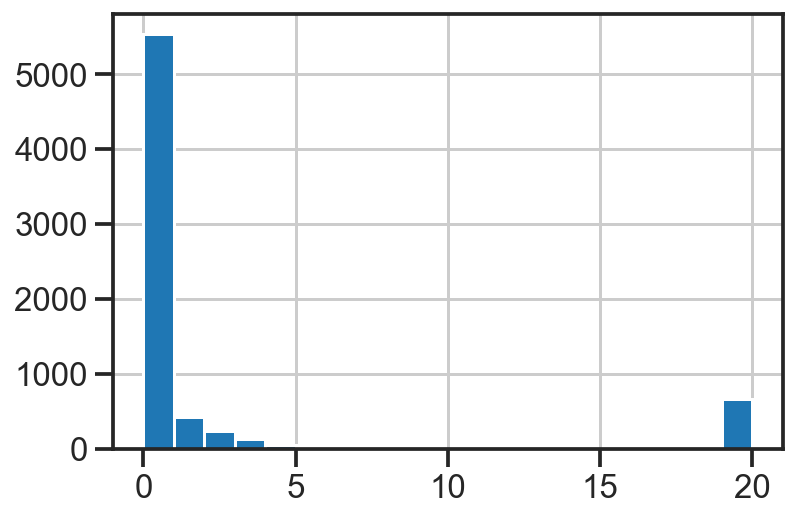

In [7]:
# qvalues have low resolution (1e-4)
_x = -np.log10(mat_qval).values
print(np.max(_x[np.isfinite(_x)]))

_x = -np.log10(mat_qval+1e-20).values

fig, ax = plt.subplots()
ax.hist(np.hstack(_x), bins=20)
plt.show()

## Qvalue - high resolutions 

In [8]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
#                                for max(0, N - (M-n)) <= k <= min(n, N)
# k/x - sample positives 
# M - all
# N - samples
# n - all positives
# # stats.hypergeom.sf(x, M, n, N) # 1-cdf

# k - fg positives; mat_fg
# M - all regions; mat_fg + mat_nfg + mat_bg + mat_nbg
# N - fg regions; mat_fg + mat_nfg
# n - all positives; mat_fg + mat_bg 

def hypogeom_test_pipe(k, M, n, N, mode='enrichment'):
    """multiple correction on each col
    """
    # enrichment pvalue (one-sided); 20s
    if mode == 'enrichment':
        pvals = stats.hypergeom.sf(k, M, n, N)
    elif mode == 'depletion':
        pvals = stats.hypergeom.cdf(k, M, n, N)
    else:
        raise ValueError
        
    pvals = pd.DataFrame(pvals, index=k.index, columns=k.columns)

    # adj pvalues
    adjpvals = pd.DataFrame(index=k.index, columns=k.columns)
    for col in pvals:
        _, adjpval, _, _ = multipletests(pvals[col], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        adjpvals[col] = adjpval
    
    return pvals, adjpvals

In [9]:
k = mat_fg
M = mat_fg+mat_nfg+mat_bg+mat_nbg
N = mat_fg+mat_nfg
n = mat_fg+mat_bg

_, adjpvals_v0 = hypogeom_test_pipe(k, M, n, N)
log2fc_v0 = np.log2((k/N)/(n/M))

<ipython-input-9-b4cacb762157>:7: RuntimeWarning: divide by zero encountered in log2
  log2fc_v0 = np.log2((k/N)/(n/M))


In [10]:
# qvalues clip at 1e-20
_x = -np.log10(adjpvals_v0).values
print(np.max(_x[np.isfinite(_x)]))

_x = np.clip(-np.log10(adjpvals_v0).values, 0, 20)
print(np.max(_x[np.isfinite(_x)]))

fig, ax = plt.subplots()
ax.hist(np.hstack(_x), bins=20)
plt.show()

<ipython-input-10-401adae544d5>:2: RuntimeWarning: divide by zero encountered in log10
  _x = -np.log10(adjpvals_v0).values
<ipython-input-10-401adae544d5>:5: RuntimeWarning: divide by zero encountered in log10
  _x = np.clip(-np.log10(adjpvals_v0).values, 0, 20)


321.23802948136967
20.0


# Improve visualization
- Cluster motifs and enhancer groups 
- Filter motifs: include motifs that are enriched (FDR<0.1) in at least 1 cell type
- Merge similar motifs (adhoc)

In [11]:
to_plot = np.clip(-np.log10(adjpvals_v0), 0, 20)
to_plot2 = log2fc_v0 

# filter motifs
fdr_th = 10 # 10^-10
log2fc_th = 0.1
cond = (((to_plot>fdr_th) & (to_plot2>log2fc_th)).sum(axis=1) > 0) # positive in at least 1 group

to_plot = to_plot[cond].copy()
to_plot2 = to_plot2[cond].copy()
print(to_plot.shape)
print(to_plot2.shape)

# merge motifs (adhoc)
if MERGE_SIMILAR_MOTIFS_ADHOC:
    to_plot['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot.index]
    to_plot = to_plot.groupby('motif_clst').max()
    print(to_plot.shape)
    
    to_plot2['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot2.index]
    to_plot2 = to_plot2.groupby('motif_clst').max()
    print(to_plot2.shape)
    
mat_labels = [
    'all', 'correlated', 'linked',
]

mats = [
    to_plot.filter(regex=r'_all$', axis=1),    
    to_plot.filter(regex=r'_correlated$', axis=1),    
    to_plot.filter(regex=r'_linked$', axis=1),    
]

mats2 = [
    to_plot2.filter(regex=r'_all$', axis=1),    
    to_plot2.filter(regex=r'_correlated$', axis=1),    
    to_plot2.filter(regex=r'_linked$', axis=1),    
]

(111, 30)
(111, 30)


<ipython-input-11-6a79821f16d7>:1: RuntimeWarning: divide by zero encountered in log10
  to_plot = np.clip(-np.log10(adjpvals_v0), 0, 20)


In [12]:
# hierarchical clustering (motif and cluster order)
pmat = mats[0]>fdr_th

Z = sch.linkage(pmat, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
motif_orders = np.array(g['ivl']).astype(int)

Z = sch.linkage(pmat.T, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

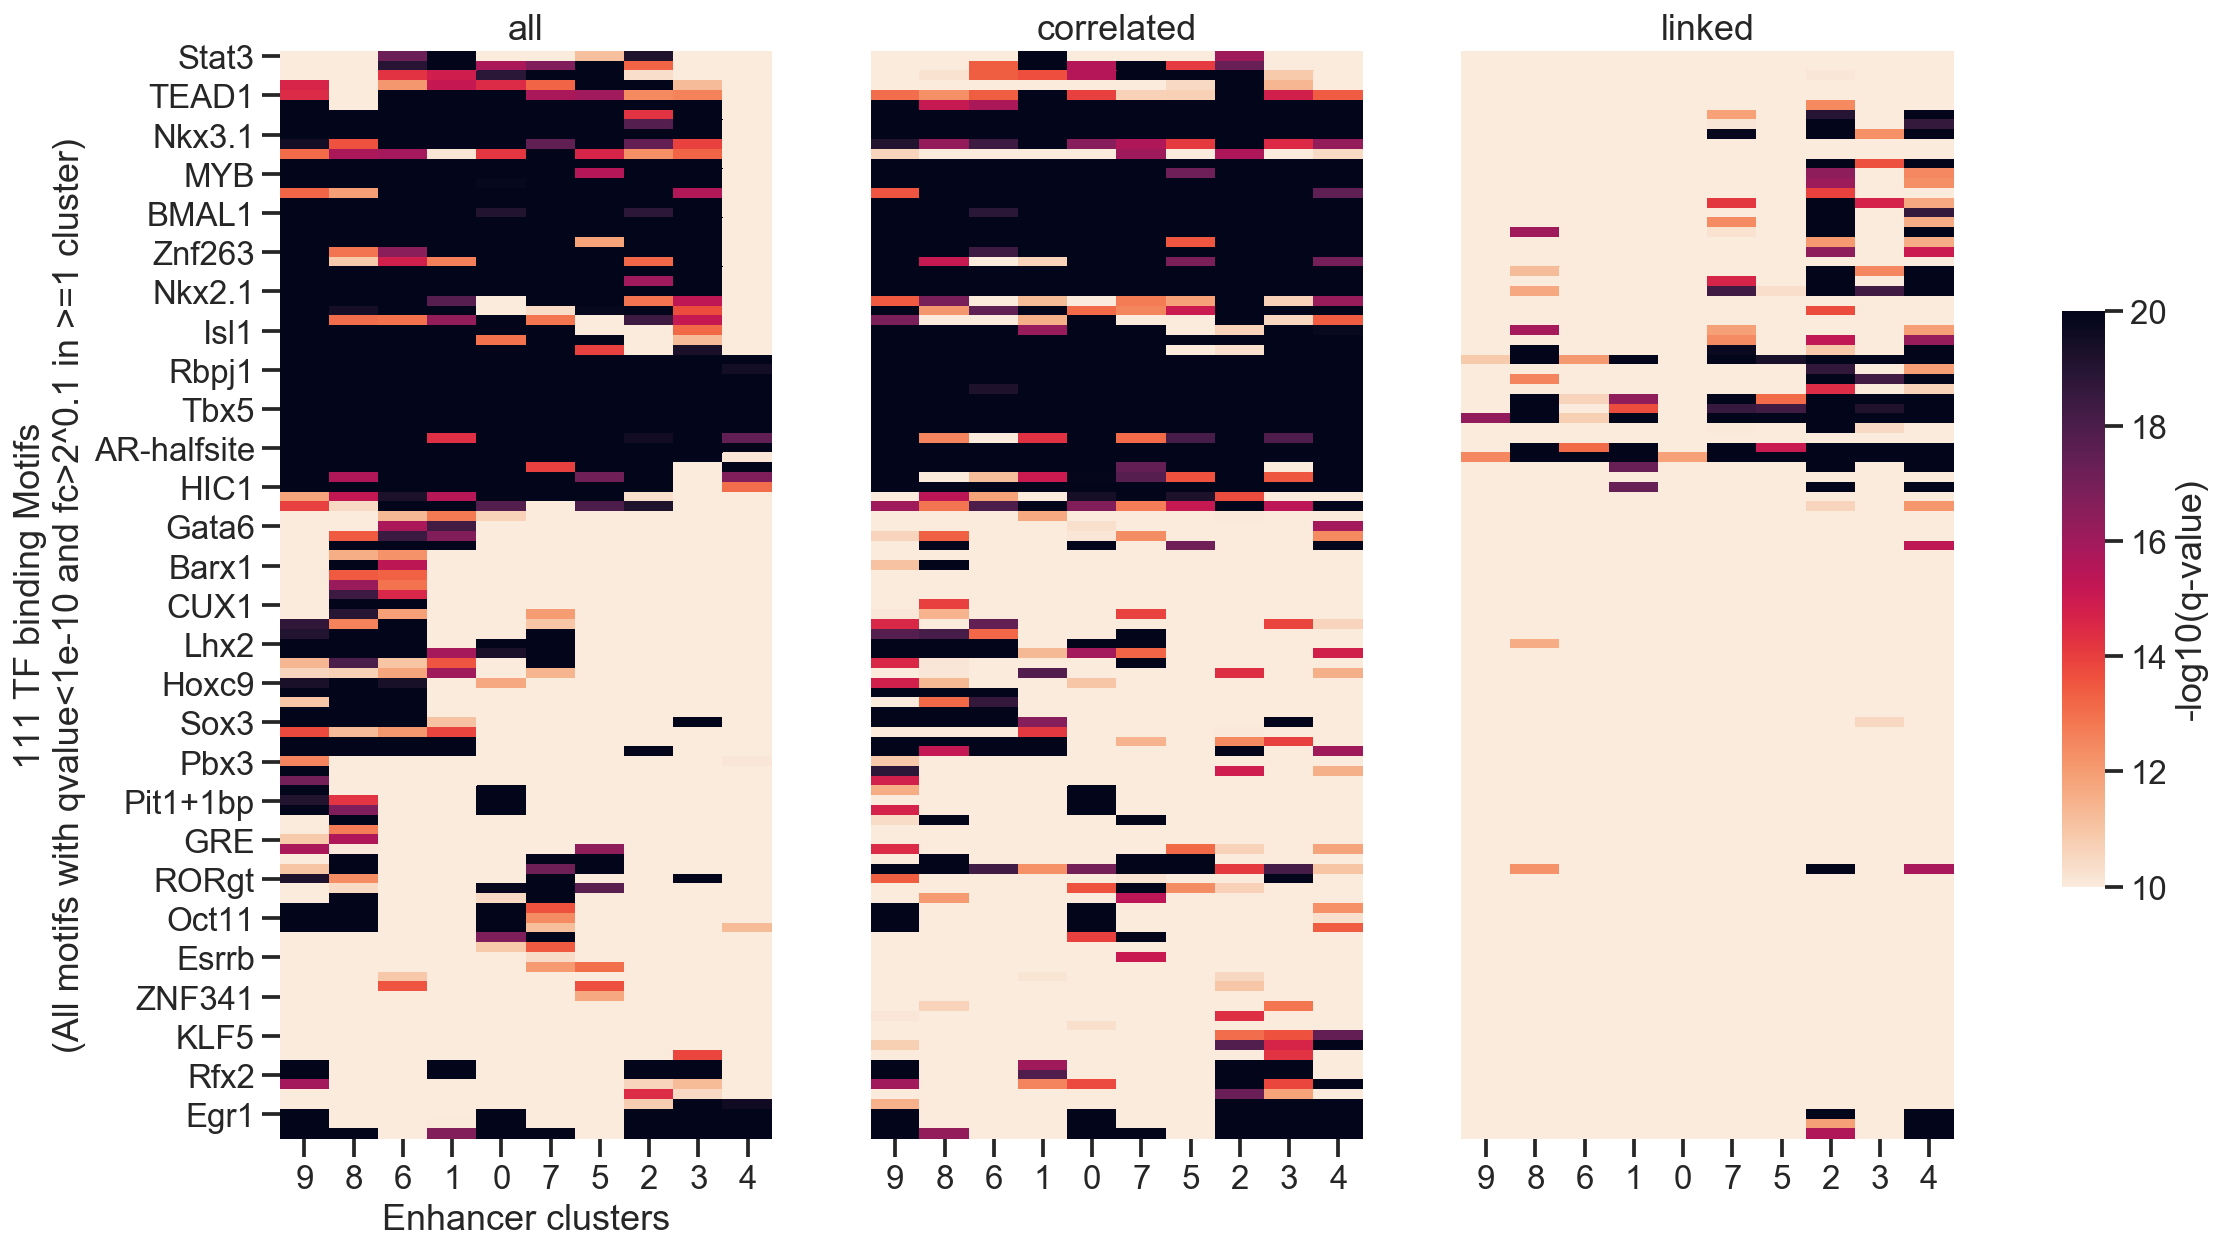

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=10, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(q-value)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    
snmcseq_utils.savefig(fig, output_figures.format('heatmaps_qvals_motif'))
plt.show()

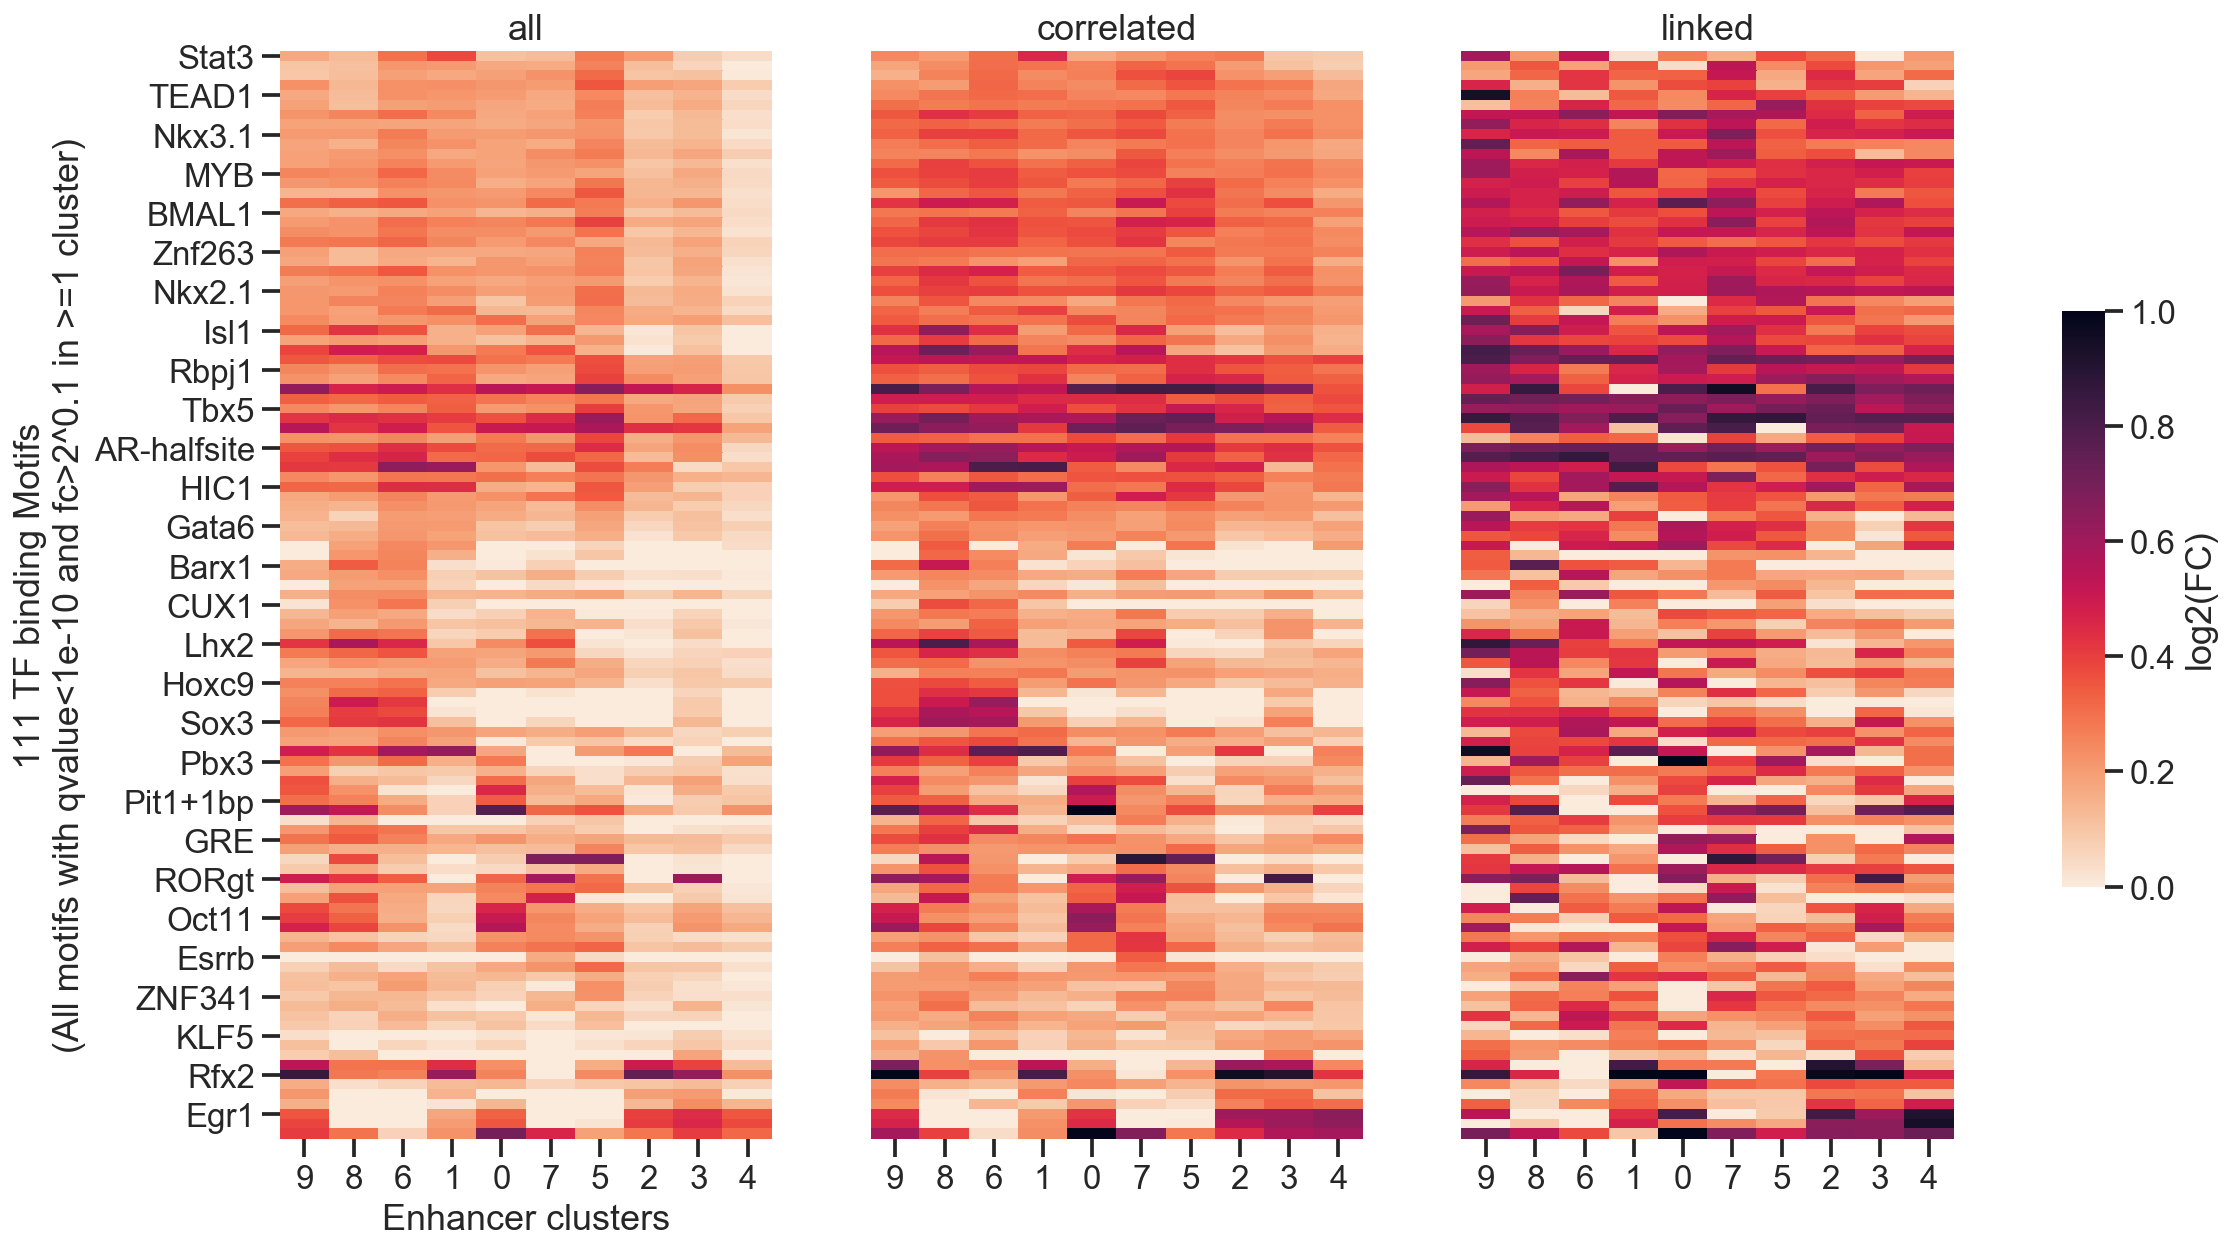

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, 
                vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

snmcseq_utils.savefig(fig, output_figures.format('heatmaps_fc_motif'))
plt.show()

In [15]:
import itertools

boxplot_df = pd.DataFrame(columns=mat_labels)
for i, (mat, label) in enumerate(zip(mats2, mat_labels)):
    boxplot_df[label] = np.hstack(mat.values)
    
for a, b in itertools.combinations(mat_labels, 2):
    t, p = stats.ttest_rel(boxplot_df[a], boxplot_df[b])
    print(a, b, t, p)

fig, ax = plt.subplots(figsize=(3,4))
sns.violinplot(data=boxplot_df, ax=ax)
ax.set_xlabel('Enhancer types')
ax.set_ylabel('log2(FC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Overall motif enrichment (each point is the log2(FC) of'
             '\n a motif in an enhancer cluster compared with random regions)')

ax.hlines([1.2], xmin=0, xmax=1)
ax.text(0.5, 1.2, '***', ha='center')
ax.hlines([1.4], xmin=1, xmax=2)
ax.text(1.5, 1.4, '***', ha='center')
ax.hlines([1.6], xmin=0, xmax=2)
ax.text(1, 1.6, '***', ha='center')
sns.despine(ax=ax)

snmcseq_utils.savefig(fig, output_figures.format('violin_plot_motif_enrichment'))
plt.show()

all correlated -48.84224697233987 1.1618373195044495e-278
all linked -27.3118255337683 5.044123297852772e-126
correlated linked -13.69214222048475 1.5271174368858327e-39


### Top enriched for each cluster

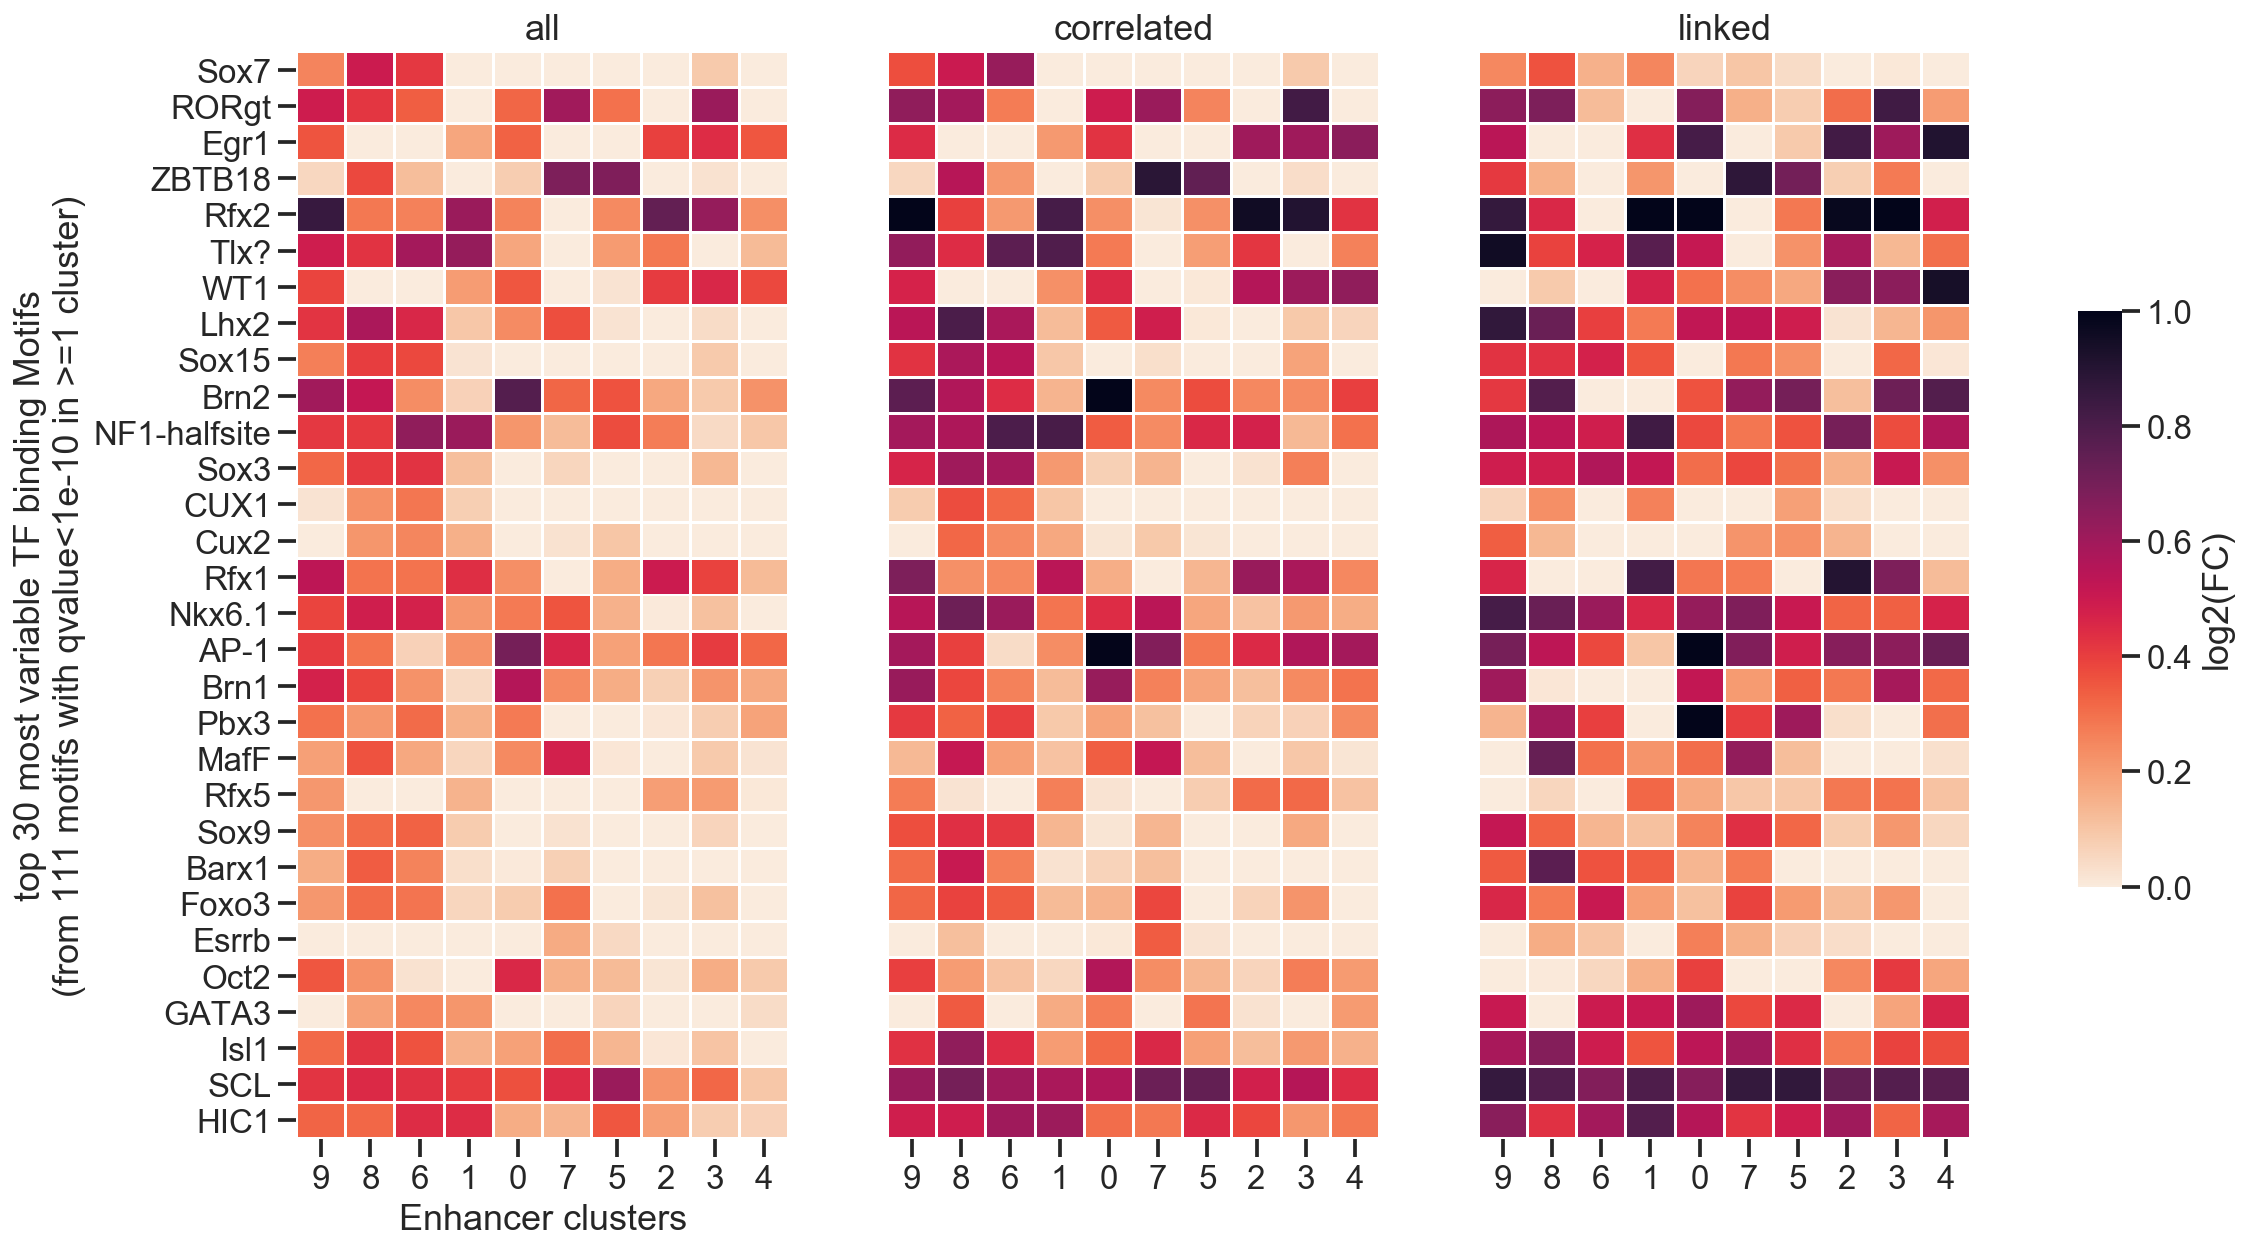

In [16]:
# most differential across enhancer clusters
ntop = 30
top_variable = mats2[0].std(axis=1).nlargest(ntop).index

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "top {} most variable TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[:,clst_orders].reindex(top_variable),  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormal

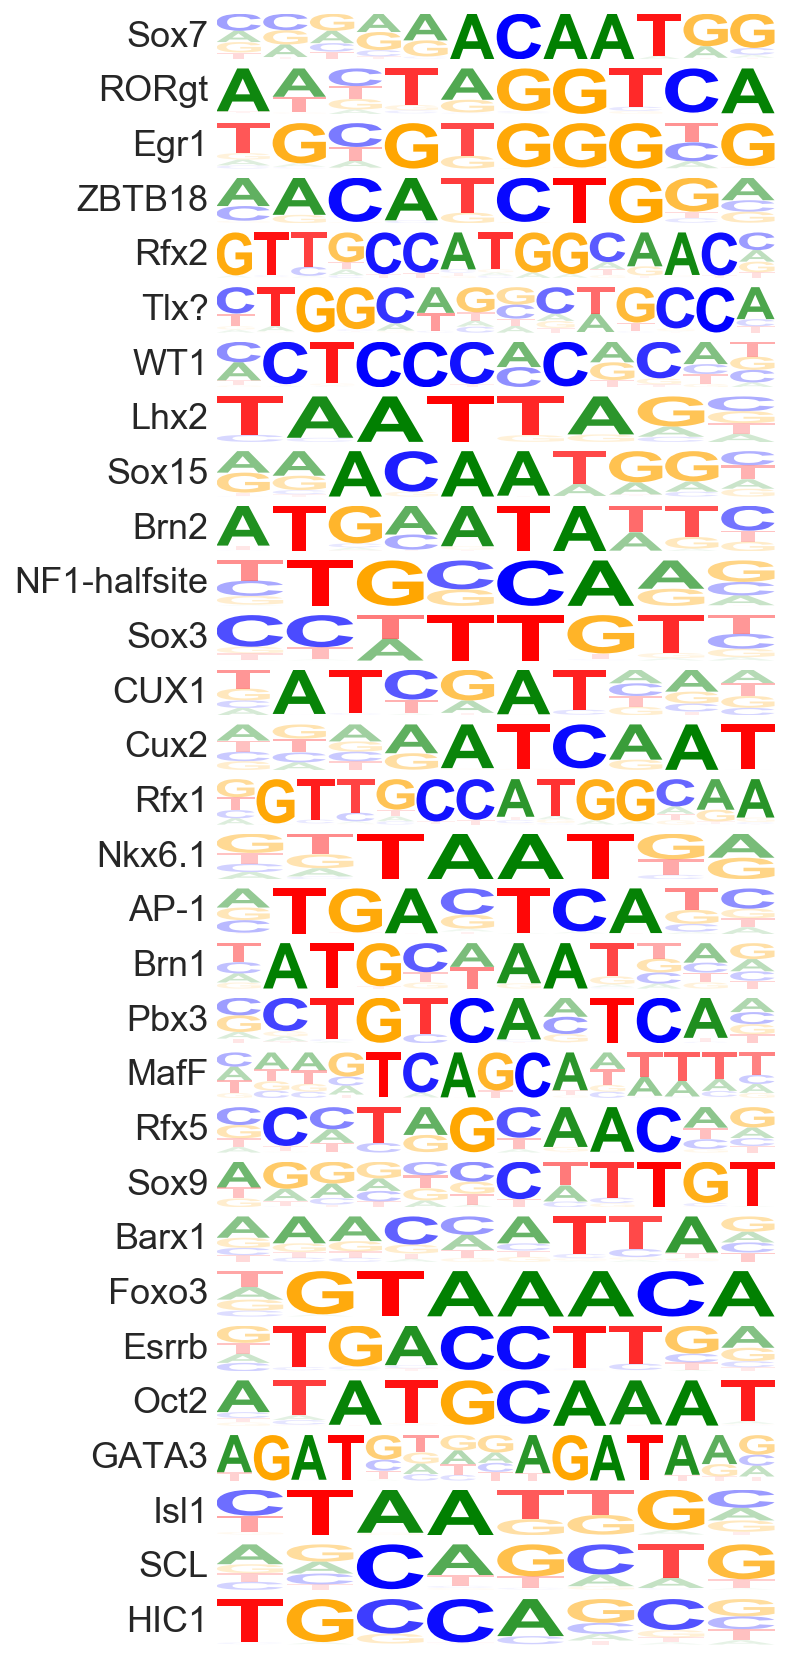

In [17]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, top_variable.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   fade_probabilities=True,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [18]:
ntop = 30

# most differential between the top enriched and the second top
# new order
sorted_mat = np.sort(mats2[0].values, axis=1)
specific_motif_order = np.argsort(sorted_mat[:,-1]-sorted_mat[:,-2])[::-1][:ntop]

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "top {} most specific TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[specific_motif_order, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [19]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, pmat.iloc[specific_motif_order].index.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   fade_probabilities=True,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormal

# Compare enrichment and depletion within a category 

In [20]:
# now fg ~ linked fg; bg ~ fg all
k = mat_fg.filter(regex=r"_linked$")
M = mat_fg.filter(regex=r'_all$')+mat_nfg.filter(regex=r"_all$")
N = mat_fg.filter(regex=r"_linked$")+mat_nfg.filter(regex=r"_linked$")
n = mat_fg.filter(regex=r"_all$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v1 = hypogeom_test_pipe(k, M, n, N)
log2fc_v1 = np.log2((k/N)/(n/M))
# log2fc_v1 = pd.DataFrame(
#     np.log2((k.values/N.values)/(n.values/M.values)),
#     index=k.index,
#     columns=k.columns,
# )

# now fg ~ linked fg; bg ~ fg correlated
k = mat_fg.filter(regex=r"_linked$")
M = mat_fg.filter(regex=r'_correlated$')+mat_nfg.filter(regex=r"_correlated$")
N = mat_fg.filter(regex=r"_linked$")+mat_nfg.filter(regex=r"_linked$")
n = mat_fg.filter(regex=r"_correlated$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v2 = hypogeom_test_pipe(k, M, n, N)
log2fc_v2 = np.log2((k/N)/(n/M))

# now fg ~ correlated fg; bg ~ fg all
k = mat_fg.filter(regex=r"_correlated$")
M = mat_fg.filter(regex=r'_all$')+mat_nfg.filter(regex=r"_all$")
N = mat_fg.filter(regex=r"_correlated$")+mat_nfg.filter(regex=r"_correlated$")
n = mat_fg.filter(regex=r"_all$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v3 = hypogeom_test_pipe(k, M, n, N)
log2fc_v3 = np.log2((k/N)/(n/M))


<ipython-input-20-1f6478a9d09a>:9: RuntimeWarning: divide by zero encountered in log2
  log2fc_v1 = np.log2((k/N)/(n/M))
<ipython-input-20-1f6478a9d09a>:24: RuntimeWarning: divide by zero encountered in log2
  log2fc_v2 = np.log2((k/N)/(n/M))
<ipython-input-20-1f6478a9d09a>:34: RuntimeWarning: divide by zero encountered in log2
  log2fc_v3 = np.log2((k/N)/(n/M))


In [21]:
# # qvalues clip at 1e-20
# for adjpvals_v in [
#         adjpvals_v1, 
#         adjpvals_v2, 
#         adjpvals_v3, 
#     ]:
#     _x = np.clip(-np.log10(adjpvals_v2).values, 0, 20)
#     print(np.max(_x[np.isfinite(_x)]))
    
#     fig, ax = plt.subplots()
#     ax.hist(np.hstack(_x), bins=20)
#     plt.show()
# k/N
# (k/N)/(n/M)

# visualization

In [22]:
to_plots = [
    np.clip(-np.log10(adjpvals_v1), 0, 20),
    np.clip(-np.log10(adjpvals_v2), 0, 20),
    np.clip(-np.log10(adjpvals_v3), 0, 20),
]

to_plots2 = [
    np.clip(log2fc_v1.fillna(0), 0, 2),
    np.clip(log2fc_v2.fillna(0), 0, 2),
    np.clip(log2fc_v3.fillna(0), 0, 2),
]
# filter motifs
fdr_th = 2 # 10^-2
log2fc_th = np.log2(1.5) 
conds = [
    ((to_plot>fdr_th) & (to_plot2>log2fc_th)).sum(axis=1) > 0
    for to_plot, to_plot2 in zip(to_plots, to_plots2)
]
cond = ((conds[0]) | (conds[1]) | (conds[2]))
print(len(cond), cond.sum())

mat_labels = [
    'linked vs all', 
    'linked vs correlated',
    'correlated vs all', 
]

mats = [to_plot[cond].copy() for to_plot in to_plots]
mats2 = [to_plot[cond].copy() for to_plot in to_plots2]

# merge motifs (adhoc)
if MERGE_SIMILAR_MOTIFS_ADHOC:
    for i in np.arange(len(mats)):
        mats[i]['motif_clst'] = [similar_motif_dict[motif] 
                                 for motif in mats[i].index]
        mats[i] = mats[i].groupby('motif_clst').max()
    for i in np.arange(len(mats2)):
        mats2[i]['motif_clst'] = [similar_motif_dict[motif] 
                                 for motif in mats2[i].index]
        mats2[i] = mats2[i].groupby('motif_clst').max()

234 146


<ipython-input-22-1df2dd38a0ab>:3: RuntimeWarning: divide by zero encountered in log10
  np.clip(-np.log10(adjpvals_v2), 0, 20),
<ipython-input-22-1df2dd38a0ab>:4: RuntimeWarning: divide by zero encountered in log10
  np.clip(-np.log10(adjpvals_v3), 0, 20),


In [23]:
# hierarchical clustering (motif and cluster order)
pmat = mats[0]

Z = sch.linkage(pmat, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
motif_orders = np.array(g['ivl']).astype(int)

Z = sch.linkage(pmat.T, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=2, vmax=10, 
                cbar=cbar, cbar_kws={'label': '-log10(q-value)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, vmax=2, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

In [ ]:
sns.distplot(np.clip(np.hstack(log2fc_v1.values), 0, 3))